In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('solar_weather.csv')
df

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


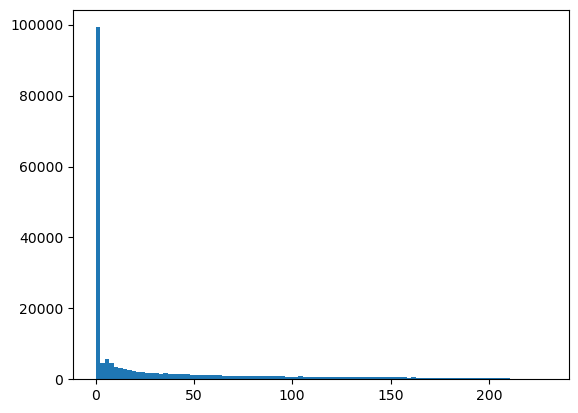

In [3]:
rad = df['GHI']

plt.hist(rad, bins=100)
plt.show()




## LSTM NN

In [3]:
import lstm
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        val_size=0.25,
        test_size=0.15,
        target_col=target_col,  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        use_log_transform=False, #figured out this one is super important
        use_power_transform=True,
        min_radiation_for_log=0.001,
        min_radiation_floor=0.0,
        clip_original_target_before_transform=False,
        original_clip_lower_percentile=10,
        original_clip_upper_percentile=90,
        clip_log_target=True,
        log_clip_lower_percentile=1,
        log_clip_upper_percentile=99,
        min_target_threshold=None
)


Adding solar elevation proxy feature
SolarElevation created for 196776 rows, 100.0% of data
Applying Yeo-Johnson Power Transform to 'Radiation'
Applying floor of 0.0 to 'Radiation' before Power Transform.
Yeo-Johnson applied (lambda=-0.1973). New target: 'Radiation_yeo'
Added 'Radiation_is_low' feature (threshold: 0.0000)
Final selected features before scaling (24): ['DaylightMinutes', 'DaylightPosition', 'HourOfDay', 'Humidity', 'IsDaylight', 'Month', 'Pressure', 'Radiation', 'Radiation_is_low', 'SolarElevation', 'Speed', 'SunlightTime/daylength', 'Temperature', 'TimeMinutesCos', 'TimeMinutesSin', 'clouds_all', 'dayLength', 'hour', 'isSun', 'month', 'rain_1h', 'snow_1h', 'sunlightTime', 'weather_type']
Using MinMaxScaler for feature scaling.
Using StandardScaler for Yeo-Johnson transformed target 'Radiation_yeo'.
DEBUG [PREPARE DATA]: Stats for target 'Radiation_yeo' BEFORE scaling: Mean=1.2850, Std=1.3380, Min=-0.0000, Max=3.3353
DEBUG [PREPARE DATA]: Stats for target 'Radiation_yeo'

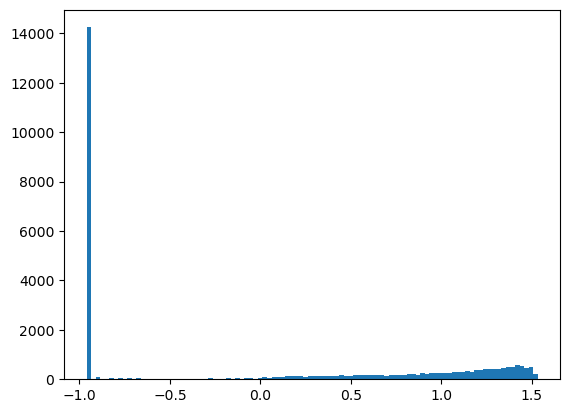

In [4]:
#plot train vals
plt.hist(y_test, bins=100)
plt.show()


In [12]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=10,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-05-07 00:11:15,372] A new study created in memory with name: no-name-47549ce8-4edd-4073-a335-7b4f6ac22636


X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24)

[I 2025-05-07 00:21:44,091] Trial 0 finished with value: 0.9860718552107887 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.0002798147512833591, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 0 with value: 0.9860718552107887.


Trial 0: hidden_dim=64, num_layers=1, dropout_prob=0.3, learning_rate=0.000280, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9861
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=10
Epoch 5/10 - Train loss: 0.134184 - Val loss: 0.106668 - Val RMSE: 0.183167 - Val R²: 0.966958 - Val MAPE: 8.31%
Epoch 5/10 - Train loss: 0.026332 - Val loss: 0.016412 - Val RMSE: 0.128108 - Val R²: 0.983837 - Val MAPE: 4.89%
Epoch 1/10 - Train loss: 0.434747 - Val loss: 0.288563 - Val RMSE: 0.149474 - Val R²: 0.977996 - Val MAPE: 6.42%
Epoch 4/10 - Train loss: 0.034778 - Val loss: 0.018202 - Val RMSE: 0.134913 - Val R²: 0.982074 - Val MAPE: 5.31%
Epoch 6/10 - Train loss: 0.127865 - Va

[I 2025-05-07 00:28:30,868] Trial 4 finished with value: 0.9870255732052284 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00017485230352172503, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 4 with value: 0.9870255732052284.


Trial 4: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000175, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9870
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 7/10 - Train loss: 0.121623 - Val loss: 0.084211 - Val RMSE: 0.098916 - Val R²: 0.990364 - Val MAPE: 3.71%
Epoch 9/10 - Train loss: 0.100253 - Val loss: 0.089159 - Val RMSE: 0.161747 - Val R²: 0.974234 - Val MAPE: 7.71%
Epoch 2/10 - Train loss: 0.020260 - Val loss: 0.017292 - Val RMSE: 0.131501 - Val R²: 0.982970 - Val MAPE: 5.44%
Epoch 4/10 - Train loss: 0.057251 - Val loss: 0.030935 - Val RMSE: 0.097444 - Val R²: 0.990649 - Val MAPE: 3.17%
Epoch 4/10 - Train loss: 0.066975 - Val loss: 0.034135 - Val RMSE: 0.109880 - Val R²: 0.988109 - Val MAPE: 3.73%
Epoch 2/10 - Tra

[I 2025-05-07 00:30:59,654] Trial 9 finished with value: 0.9724564526188672 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.00018354330320683736, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 4 with value: 0.9870255732052284.


Trial 9: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000184, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9725
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=10
Epoch 10/10 - Train loss: 0.024252 - Val loss: 0.015952 - Val RMSE: 0.126300 - Val R²: 0.984290 - Val MAPE: 4.55%
Training complete. Best model saved.


[I 2025-05-07 00:31:28,575] Trial 8 finished with value: 0.98429010398035 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0006112927810075212, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 4 with value: 0.9870255732052284.


Trial 8: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000611, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9843
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.5, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 10/10 - Train loss: 0.105859 - Val loss: 0.084650 - Val RMSE: 0.105010 - Val R²: 0.989140 - Val MAPE: 3.91%
Training complete. Best model saved.


[I 2025-05-07 00:31:42,258] Trial 12 finished with value: 0.9891399479894664 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0006765313744323562, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9891399479894664.


Trial 12: hidden_dim=64, num_layers=1, dropout_prob=0.1, learning_rate=0.000677, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9891
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=10
Epoch 7/10 - Train loss: 0.028183 - Val loss: 0.011747 - Val RMSE: 0.108384 - Val R²: 0.988431 - Val MAPE: 4.08%
Epoch 1/10 - Train loss: 0.644005 - Val loss: 0.604303 - Val RMSE: 0.242595 - Val R²: 0.942040 - Val MAPE: 9.18%
Epoch 5/10 - Train loss: 0.045534 - Val loss: 0.040436 - Val RMSE: 0.097798 - Val R²: 0.990580 - Val MAPE: 3.03%
Epoch 5/10 - Train loss: 0.060615 - Val loss: 0.034908 - Val RMSE: 0.107276 - Val R²: 0.988666 - Val MAPE: 3.91%
Epoch 8/10 - Train loss: 0.027237 - Val loss: 0.012082 - Val RMSE: 0.109917 - Val R²: 0.988101 - Val MAPE: 4.27%


[I 2025-05-07 00:40:31,511] Trial 1 finished with value: 0.9879030880312281 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00022877202223374124, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.5}. Best is trial 12 with value: 0.9891399479894664.


Trial 1: hidden_dim=64, num_layers=3, dropout_prob=0.2, learning_rate=0.000229, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9879
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=10
Epoch 1/10 - Train loss: 0.614292 - Val loss: 0.590072 - Val RMSE: 0.216852 - Val R²: 0.953688 - Val MAPE: 9.08%
Epoch 4/10 - Train loss: 0.429000 - Val loss: 0.344611 - Val RMSE: 0.173108 - Val R²: 0.970488 - Val MAPE: 6.56%
Epoch 2/10 - Train loss: 0.512191 - Val loss: 0.465855 - Val RMSE: 0.205215 - Val R²: 0.958525 - Val MAPE: 8.92%
Epoch 3/10 - Train loss: 0.485975 - Val loss: 0.421120 - Val RMSE: 0.195283 - Val R²: 0.962443 - Val MAPE: 7.97%
Epoch 7/10 - Train loss: 0.044251 - Va

[I 2025-05-07 00:50:44,992] Trial 17 finished with value: 0.9725715652577129 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.00011085086358051412, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9891399479894664.


Trial 17: hidden_dim=64, num_layers=1, dropout_prob=0.2, learning_rate=0.000111, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9726
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=10
Epoch 3/10 - Train loss: 0.021669 - Val loss: 0.012182 - Val RMSE: 0.110373 - Val R²: 0.988002 - Val MAPE: 4.09%
Epoch 1/10 - Train loss: 0.482992 - Val loss: 0.399041 - Val RMSE: 0.219949 - Val R²: 0.952355 - Val MAPE: 9.93%
Epoch 8/10 - Train loss: 0.268819 - Val loss: 0.176125 - Val RMSE: 0.152278 - Val R²: 0.977163 - Val MAPE: 5.88%
Epoch 9/10 - Train loss: 0.039242 - Val loss: 0.032383 - Val RMSE: 0.084718 - Val R²: 0.992932 - Val MAPE: 2.95%
Epoch 9/10 - Train loss: 0.044678 - Val loss: 0.035994 - Val RMSE: 0.097222 - Val R²: 0.990691 - Val MAPE: 3.28%
E

[I 2025-05-07 00:59:33,086] Trial 14 finished with value: 0.9785149184831734 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.0002790104417496944, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9891399479894664.


Trial 14: hidden_dim=64, num_layers=3, dropout_prob=0.3, learning_rate=0.000279, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9785
X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.1, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=10
Epoch 10/10 - Train loss: 0.040342 - Val loss: 0.031117 - Val RMSE: 0.088930 - Val R²: 0.992211 - Val MAPE: 2.86%
Training complete. Best model saved.


[I 2025-05-07 01:01:10,032] Trial 11 finished with value: 0.9922113506844251 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00033718513026661807, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 11 with value: 0.9922113506844251.


Trial 11: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000337, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9922
Epoch 10/10 - Train loss: 0.048339 - Val loss: 0.039430 - Val RMSE: 0.121111 - Val R²: 0.985554 - Val MAPE: 4.34%
Training complete. Best model saved.


[I 2025-05-07 01:01:14,206] Trial 5 finished with value: 0.9855544137998872 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.0004623040581570768, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 11 with value: 0.9922113506844251.


Trial 5: hidden_dim=128, num_layers=1, dropout_prob=0.2, learning_rate=0.000462, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9856
Epoch 1/10 - Train loss: 0.268704 - Val loss: 0.212836 - Val RMSE: 0.178092 - Val R²: 0.968764 - Val MAPE: 7.53%
Epoch 5/10 - Train loss: 0.011776 - Val loss: 0.008449 - Val RMSE: 0.091917 - Val R²: 0.991679 - Val MAPE: 3.25%
Epoch 5/10 - Train loss: 0.060923 - Val loss: 0.065784 - Val RMSE: 0.143000 - Val R²: 0.979861 - Val MAPE: 5.12%
Epoch 1/10 - Train loss: 0.039796 - Val loss: 0.022188 - Val RMSE: 0.148957 - Val R²: 0.978148 - Val MAPE: 5.44%
Epoch 2/10 - Train loss: 0.194793 - Val loss: 0.173198 - Val RMSE: 0.172827 - Val R²: 0.970583 - Val MAPE: 7.20%
Epoch 3/10 - Train loss: 0.184007 - Val loss: 0.139667 - Val RMSE: 0.166816 - Val R²: 0.972594 - Val MAPE: 6.92%
Epoch 5/10 - Train loss: 0.017288 - Val loss: 0.008508 - Val RMSE: 0.092240 - Val R²: 0.991621 - Val MAPE: 3.31%
Epoch 4/10 - Train loss: 0.155257 - Val loss: 0.142703 - Val RMSE: 0.158782 

[I 2025-05-07 01:17:06,836] Trial 19 finished with value: 0.9824345363366835 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00011056557377381569, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 11 with value: 0.9922113506844251.


Trial 19: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000111, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9824
Epoch 8/10 - Train loss: 0.015434 - Val loss: 0.007180 - Val RMSE: 0.084736 - Val R²: 0.992929 - Val MAPE: 2.78%
Epoch 5/10 - Train loss: 0.322121 - Val loss: 0.206294 - Val RMSE: 0.158017 - Val R²: 0.975409 - Val MAPE: 5.63%
Epoch 5/10 - Train loss: 0.169997 - Val loss: 0.118083 - Val RMSE: 0.141302 - Val R²: 0.980336 - Val MAPE: 5.05%
Epoch 4/10 - Train loss: 0.118923 - Val loss: 0.091507 - Val RMSE: 0.103091 - Val R²: 0.989533 - Val MAPE: 3.51%
Epoch 3/10 - Train loss: 0.014733 - Val loss: 0.010556 - Val RMSE: 0.102744 - Val R²: 0.989604 - Val MAPE: 3.58%
Epoch 8/10 - Train loss: 0.010666 - Val loss: 0.007956 - Val RMSE: 0.089199 - Val R²: 0.992164 - Val MAPE: 2.96%
Epoch 8/10 - Train loss: 0.046013 - Val loss: 0.038134 - Val RMSE: 0.132589 - Val R²: 0.982687 - Val MAPE: 4.34%
Epoch 9/10 - Train loss: 0.015165 - Val loss: 0.006649 - Val RMSE: 0.081540 

[I 2025-05-07 01:27:12,316] Trial 16 finished with value: 0.9935197893058259 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.0001543197102751564, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 16: hidden_dim=256, num_layers=1, dropout_prob=0.3, learning_rate=0.000154, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9935
Epoch 9/10 - Train loss: 0.010373 - Val loss: 0.008163 - Val RMSE: 0.090348 - Val R²: 0.991961 - Val MAPE: 3.07%
Epoch 9/10 - Train loss: 0.048214 - Val loss: 0.038001 - Val RMSE: 0.129530 - Val R²: 0.983476 - Val MAPE: 4.55%
Epoch 6/10 - Train loss: 0.128283 - Val loss: 0.109427 - Val RMSE: 0.140284 - Val R²: 0.980619 - Val MAPE: 5.05%
Epoch 6/10 - Train loss: 0.285302 - Val loss: 0.213927 - Val RMSE: 0.168793 - Val R²: 0.971941 - Val MAPE: 5.74%
Epoch 5/10 - Train loss: 0.011175 - Val loss: 0.007710 - Val RMSE: 0.087809 - Val R²: 0.992406 - Val MAPE: 3.08%
Epoch 10/10 - Train loss: 0.010204 - Val loss: 0.007948 - Val RMSE: 0.089153 - Val R²: 0.992172 - Val MAPE: 3.07%
Training complete. Best model saved.


[I 2025-05-07 01:33:22,289] Trial 7 finished with value: 0.9921721356860598 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00022967005420381528, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 7: hidden_dim=128, num_layers=2, dropout_prob=0.1, learning_rate=0.000230, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9922
Epoch 10/10 - Train loss: 0.044760 - Val loss: 0.038313 - Val RMSE: 0.127390 - Val R²: 0.984018 - Val MAPE: 4.45%
Training complete. Best model saved.


[I 2025-05-07 01:33:32,981] Trial 2 finished with value: 0.984017817844174 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0003743040659338364, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 16 with value: 0.9935197893058259.


Trial 2: hidden_dim=128, num_layers=2, dropout_prob=0.2, learning_rate=0.000374, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9840
Epoch 6/10 - Train loss: 0.010800 - Val loss: 0.007979 - Val RMSE: 0.089325 - Val R²: 0.992142 - Val MAPE: 2.89%
Epoch 5/10 - Train loss: 0.113587 - Val loss: 0.108592 - Val RMSE: 0.093453 - Val R²: 0.991399 - Val MAPE: 3.08%
Epoch 4/10 - Train loss: 0.014009 - Val loss: 0.009834 - Val RMSE: 0.099168 - Val R²: 0.990315 - Val MAPE: 3.26%
Epoch 4/10 - Train loss: 0.313441 - Val loss: 0.312237 - Val RMSE: 0.158923 - Val R²: 0.975126 - Val MAPE: 7.23%
Epoch 7/10 - Train loss: 0.127961 - Val loss: 0.124816 - Val RMSE: 0.147509 - Val R²: 0.978571 - Val MAPE: 5.36%
Epoch 7/10 - Train loss: 0.259924 - Val loss: 0.205590 - Val RMSE: 0.174547 - Val R²: 0.969995 - Val MAPE: 6.00%
Epoch 7/10 - Train loss: 0.010413 - Val loss: 0.007047 - Val RMSE: 0.083947 - Val R²: 0.993060 - Val MAPE: 2.78%
Epoch 8/10 - Train loss: 0.120478 - Val loss: 0.102161 - Val RMSE: 0.133460

[I 2025-05-07 01:48:46,312] Trial 18 finished with value: 0.9930234758836515 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00046100266726909167, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 16 with value: 0.9935197893058259.


Trial 18: hidden_dim=128, num_layers=2, dropout_prob=0.1, learning_rate=0.000461, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9930
Epoch 7/10 - Train loss: 0.092374 - Val loss: 0.121566 - Val RMSE: 0.093674 - Val R²: 0.991358 - Val MAPE: 3.21%
Epoch 6/10 - Train loss: 0.013486 - Val loss: 0.010264 - Val RMSE: 0.101312 - Val R²: 0.989891 - Val MAPE: 3.48%
Epoch 6/10 - Train loss: 0.197210 - Val loss: 0.221978 - Val RMSE: 0.149961 - Val R²: 0.977852 - Val MAPE: 6.34%
Epoch 10/10 - Train loss: 0.114371 - Val loss: 0.098192 - Val RMSE: 0.129056 - Val R²: 0.983597 - Val MAPE: 4.45%
Training complete. Best model saved.


[I 2025-05-07 01:51:43,373] Trial 3 finished with value: 0.9835968631236998 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00039042580015386023, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 3: hidden_dim=128, num_layers=3, dropout_prob=0.2, learning_rate=0.000390, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9836
Epoch 10/10 - Train loss: 0.240578 - Val loss: 0.175506 - Val RMSE: 0.163347 - Val R²: 0.973722 - Val MAPE: 5.63%
Training complete. Best model saved.


[I 2025-05-07 01:51:49,751] Trial 6 finished with value: 0.9737221304428183 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.00037229053118559925, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 16 with value: 0.9935197893058259.


Trial 6: hidden_dim=128, num_layers=3, dropout_prob=0.3, learning_rate=0.000372, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9737
Epoch 7/10 - Train loss: 0.013250 - Val loss: 0.007069 - Val RMSE: 0.084077 - Val R²: 0.993038 - Val MAPE: 2.76%
Epoch 8/10 - Train loss: 0.085154 - Val loss: 0.087408 - Val RMSE: 0.109376 - Val R²: 0.988218 - Val MAPE: 3.58%
Epoch 7/10 - Train loss: 0.179214 - Val loss: 0.160590 - Val RMSE: 0.140815 - Val R²: 0.980472 - Val MAPE: 5.58%
Epoch 9/10 - Train loss: 0.085350 - Val loss: 0.089684 - Val RMSE: 0.107445 - Val R²: 0.988631 - Val MAPE: 3.56%
Epoch 8/10 - Train loss: 0.013049 - Val loss: 0.008355 - Val RMSE: 0.091408 - Val R²: 0.991771 - Val MAPE: 2.94%
Epoch 8/10 - Train loss: 0.139931 - Val loss: 0.132930 - Val RMSE: 0.142131 - Val R²: 0.980105 - Val MAPE: 4.82%
Epoch 10/10 - Train loss: 0.080961 - Val loss: 0.079455 - Val RMSE: 0.100507 - Val R²: 0.990052 - Val MAPE: 3.27%
Training complete. Best model saved.
Epoch 9/10 - Train loss: 0.012834 - Va

[I 2025-05-07 02:04:15,738] Trial 10 finished with value: 0.9900515367214856 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00043023347838231106, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 10: hidden_dim=256, num_layers=3, dropout_prob=0.1, learning_rate=0.000430, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9901
Epoch 9/10 - Train loss: 0.138874 - Val loss: 0.224755 - Val RMSE: 0.130828 - Val R²: 0.983143 - Val MAPE: 4.40%
Epoch 10/10 - Train loss: 0.012749 - Val loss: 0.011546 - Val RMSE: 0.107451 - Val R²: 0.988629 - Val MAPE: 3.65%
Training complete. Best model saved.


[I 2025-05-07 02:08:04,750] Trial 13 finished with value: 0.9886293682683958 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.0008990778508372948, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 13: hidden_dim=256, num_layers=3, dropout_prob=0.2, learning_rate=0.000899, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9886
Epoch 10/10 - Train loss: 0.130056 - Val loss: 0.122879 - Val RMSE: 0.122742 - Val R²: 0.985163 - Val MAPE: 4.04%
Training complete. Best model saved.


[I 2025-05-07 02:08:37,660] Trial 15 finished with value: 0.9851626179351519 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00011999365421622717, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9935197893058259.


Trial 15: hidden_dim=256, num_layers=3, dropout_prob=0.2, learning_rate=0.000120, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9852
Best parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.0001543197102751564, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}
Best value (R²): 0.9935


In [5]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 128  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.9 #0.7
mape_weight=0.1 #0.3
dropout_prob =0.1
 
# Initialize model
device = torch.device('mps')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store complete transform info in the model
#model.transform_info = transform_info  # Store the whole transform_info object
    

In [6]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.0005, 
        patience=30,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=0.001,#0,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        loss_type="value_aware", #'mse',
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.1 #adjust
    )


X_train shape: (118051, 24, 24), y_train shape: (118051, 1)
X_val shape: (49188, 24, 24), y_val shape: (49188, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.1, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 0.001
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=100
Epoch 1/100 - Train loss: 0.186055 - Val loss: 0.156552 - Val RMSE: 0.149058 - Val R²: 0.978118 - Val MAPE: 5.02%
Epoch 2/100 - Train loss: 0.165440 - Val loss: 0.130635 - Val RMSE: 0.147402 - Val R²: 0.978602 - Val MAPE: 4.75%
Epoch 3/100 - Train loss: 0.147774 - Val loss: 0.124949 - Val RMSE: 0.147768 - Val R²: 0.978495 - Val MAPE: 4.83%
Epoch 4/100 - Train loss: 0.147929 - Val loss: 0.138082 - Val RMSE: 0.144488 - Val R²: 0.979440 - Val MAPE: 5.17%
Epoch 5/100 - Train loss: 0.139084 - Val loss: 0.111757 - Val RMSE: 0.159277 - Val R²: 0.975015 - Val MAPE: 5.02%
Epoch 6/100 - Train loss: 0.143647 - Val loss: 0.127

WeatherLSTM(
  (lstm): LSTM(24, 128, num_layers=2, batch_first=True, dropout=0.1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

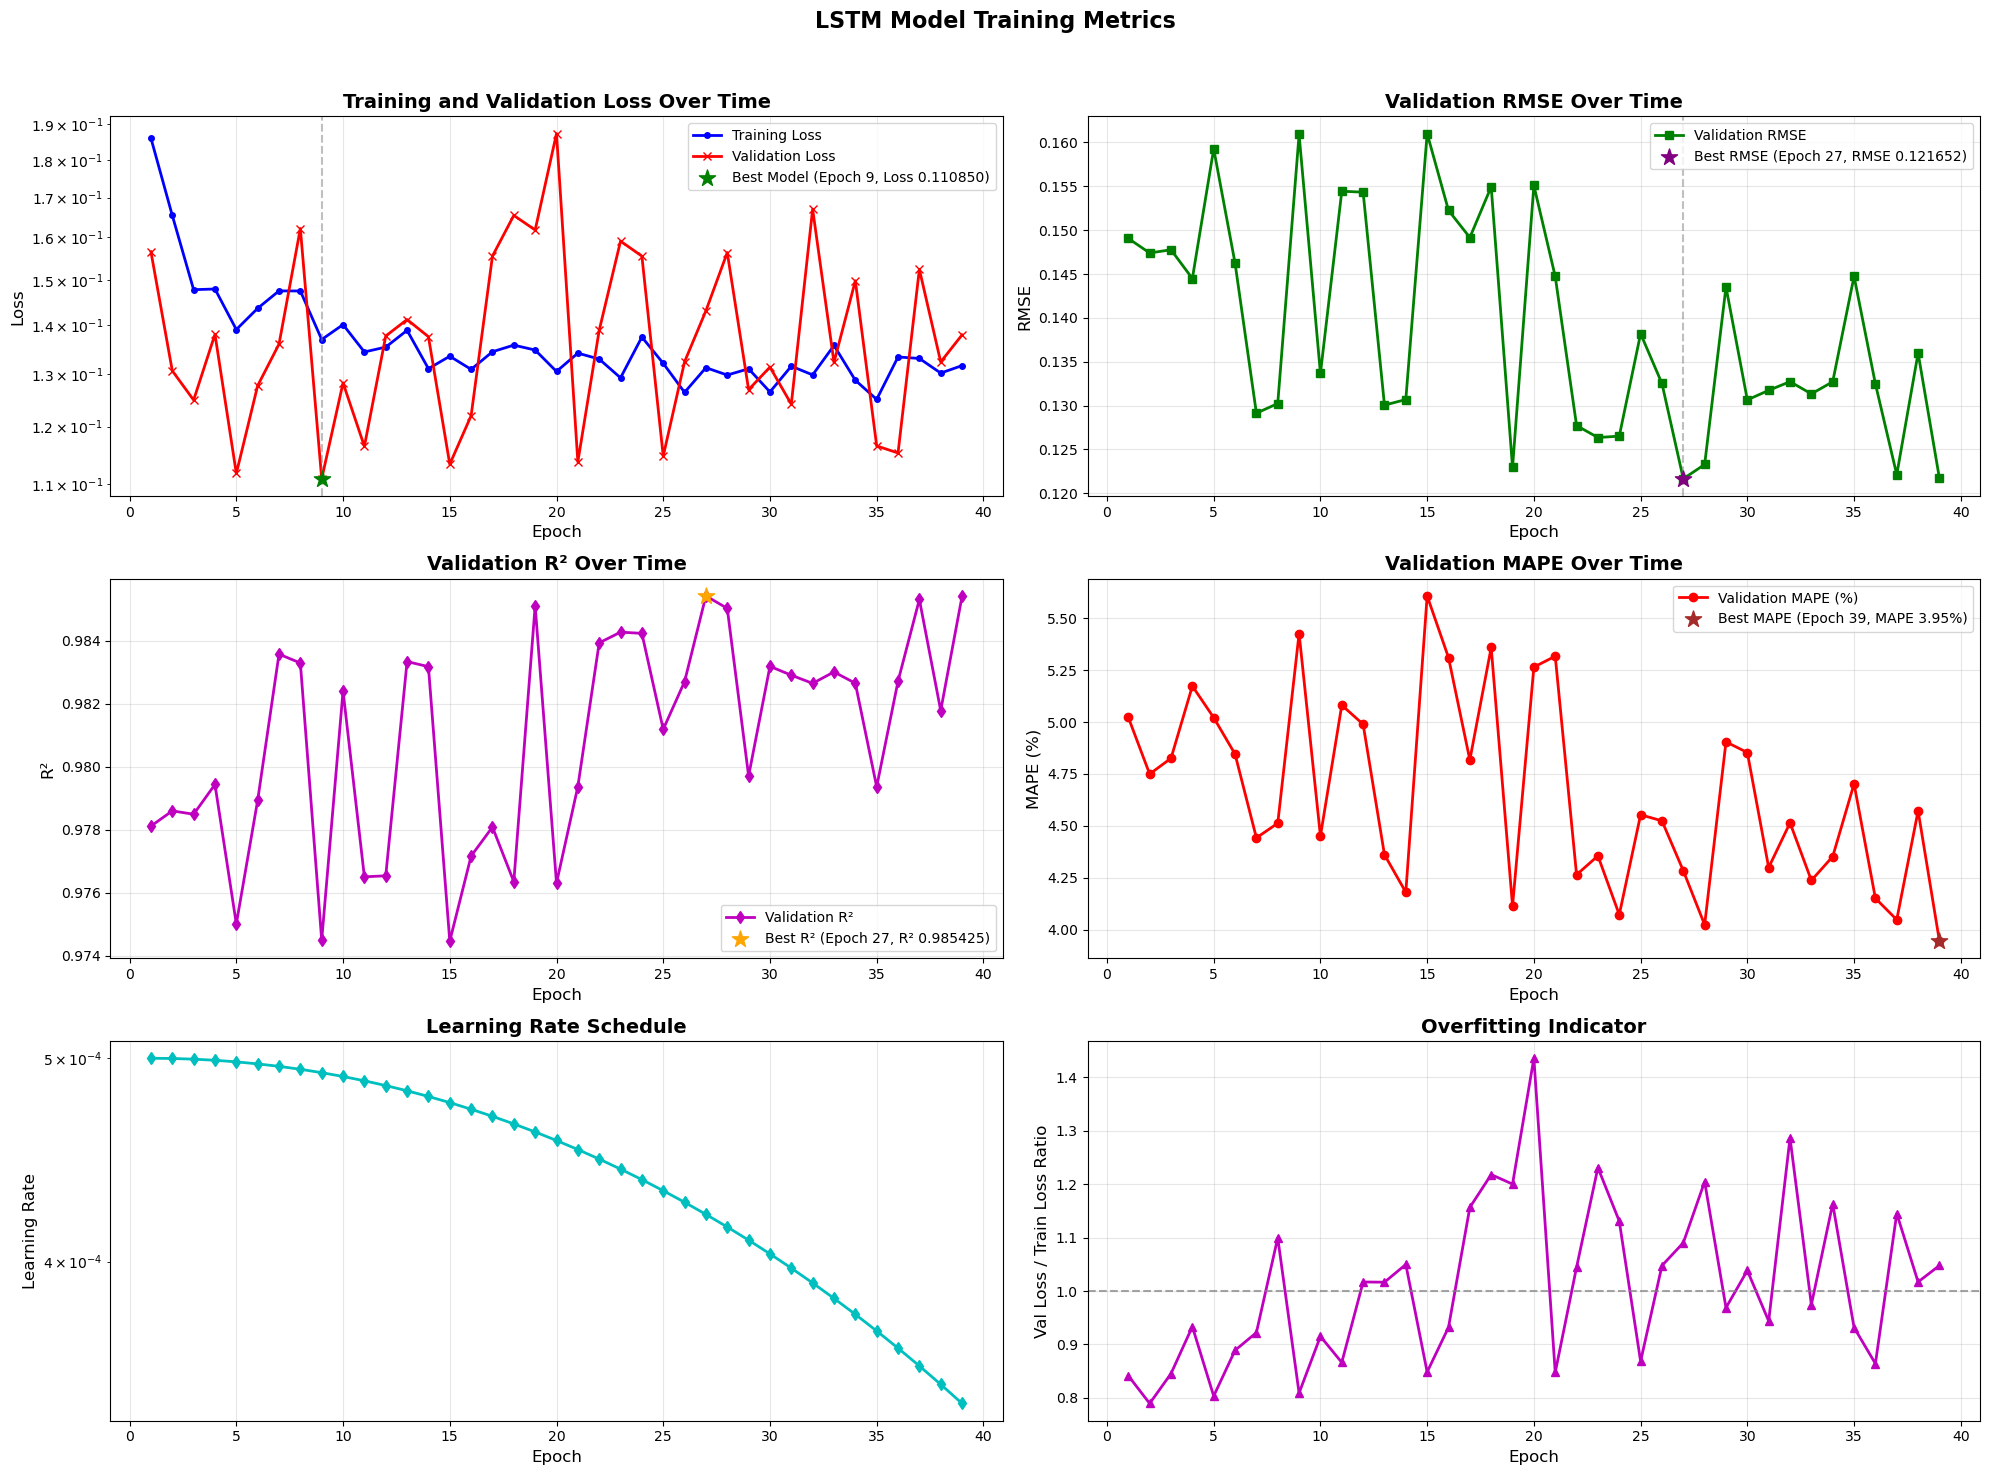

In [7]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = transform_info  # Store the whole transform_info object

In [8]:
print('transform_info', transform_info)
print('scalers', scalers)

transform_info {'transforms': [{'applied': True, 'type': 'yeo-johnson', 'lambda': -0.19729579226426472, 'original_col': 'Radiation', 'scaler_used_after': 'StandardScaler', 'original_clip_bounds': None}], 'target_col_original': 'Radiation', 'target_col_processed_name': 'Radiation', 'target_col_transformed_final': 'Radiation_yeo'}
scalers {'DaylightMinutes': MinMaxScaler(), 'DaylightPosition': MinMaxScaler(), 'HourOfDay': MinMaxScaler(), 'Humidity': MinMaxScaler(), 'IsDaylight': MinMaxScaler(), 'Month': MinMaxScaler(), 'Pressure': MinMaxScaler(), 'Radiation': MinMaxScaler(), 'Radiation_is_low': MinMaxScaler(), 'SolarElevation': MinMaxScaler(), 'Speed': MinMaxScaler(), 'SunlightTime/daylength': MinMaxScaler(), 'Temperature': MinMaxScaler(), 'TimeMinutesCos': MinMaxScaler(), 'TimeMinutesSin': MinMaxScaler(), 'clouds_all': MinMaxScaler(), 'dayLength': MinMaxScaler(), 'hour': MinMaxScaler(), 'isSun': MinMaxScaler(), 'month': MinMaxScaler(), 'rain_1h': MinMaxScaler(), 'snow_1h': MinMaxScaler(

DEBUG [EVALUATE]: Shape of actuals_std_log_np: (29513,)
DEBUG [EVALUATE]: Shape of model_predictions_std_log_np: (29513,)
DEBUG [EVALUATE]: Extracted std_dev_log for analysis: 1.3380

--- Analysis in Standardized Yeo-johnson Space ---
Number of samples: 29513
Mean of Residuals (Actuals - Predictions) in Standardized Yeo-johnson Space (K_prime): -0.0578
Std Dev of Residuals in Standardized Yeo-johnson Space: 0.8000
  Interpretation of a simple multiplicative factor (C) is specific to log transforms and not directly applicable for Yeo-Johnson.


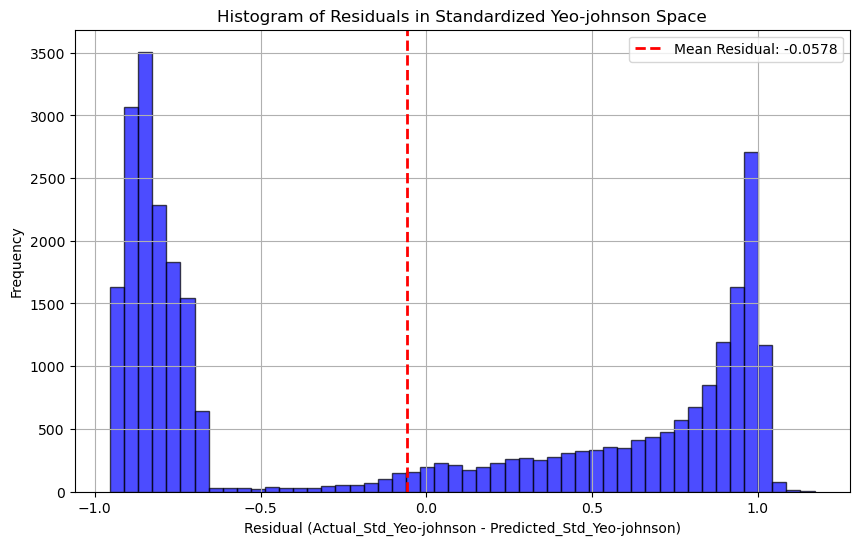

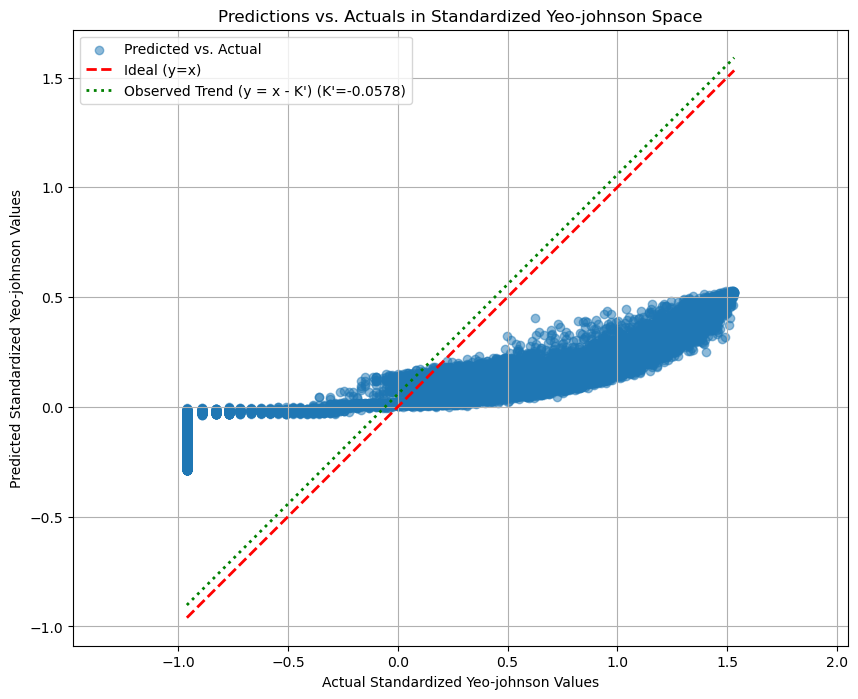


--- Scaled Metrics (Calculated in Evaluate Method) ---
Test RMSE (scaled): 0.802098
Test MAPE (scaled): 104.01%
Test MAPE (scaled, capped at 100% error per point): 80.36%

--- Calculating Original Scale Metrics ---
Applying inverse Yeo-Johnson transform (lambda=-0.1973) for column 'Radiation'
Applying inverse Yeo-Johnson transform (lambda=-0.1973) for column 'Radiation'
Test RMSE (original scale): 59.959625
Test MAPE (original scale): 12163905507.32%
Test MAPE (original scale, capped at 100% error per point): 88.57%


In [9]:


# Evaluate on test data
model_predictions_std_log_np, actuals_std_log_np, predictions_original_scale, actuals_original_scale, metrics = model.evaluate(
        X_test, y_test,
    target_scaler_object=scalers["Radiation_yeo"],
    transform_info_dict=transform_info,  # Pass the complete transform_info
    )

# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions_original_scale - actuals_original_scale) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


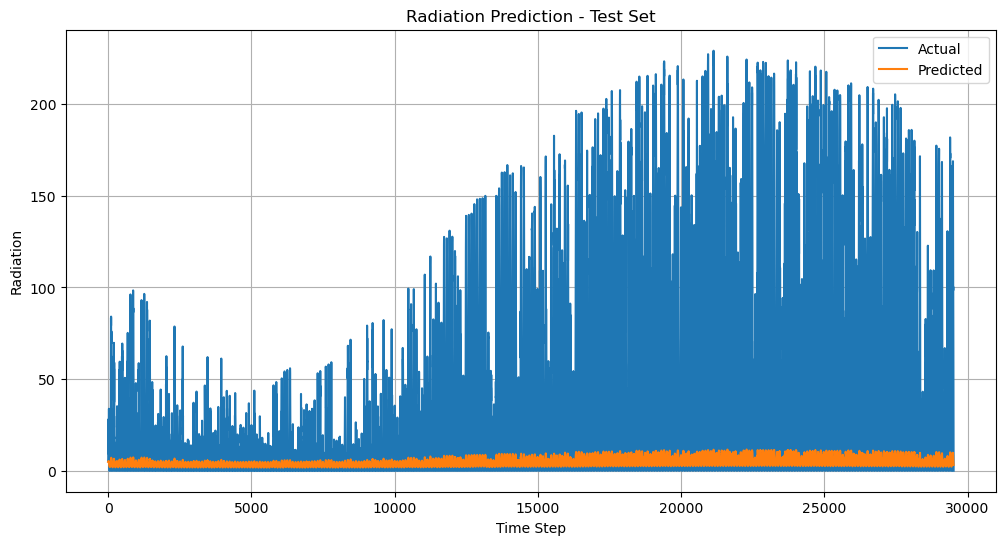

In [10]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals_original_scale, label='Actual')
plt.plot(predictions_original_scale, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

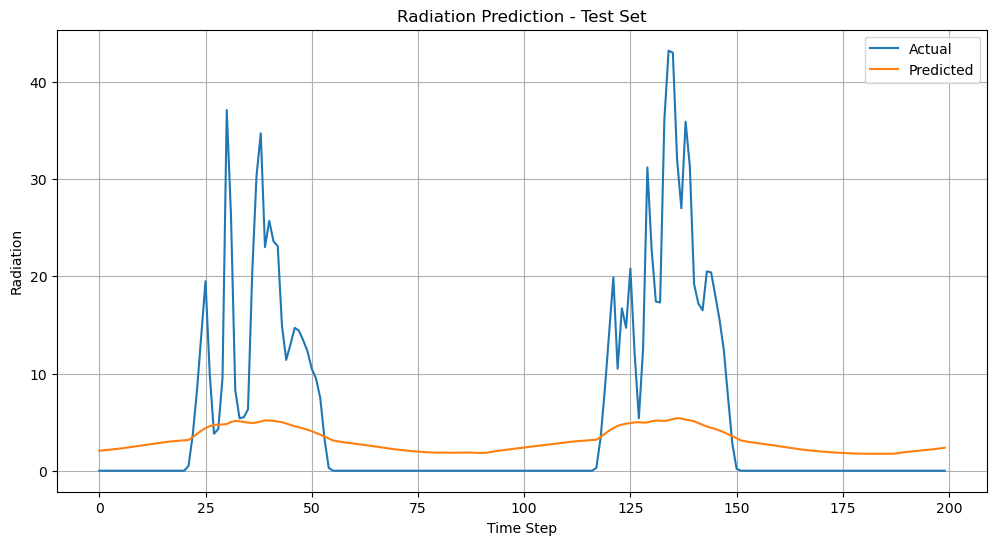

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_original_scale[2950:3150], label='Actual')
plt.plot(predictions_original_scale[2950:3150], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 4900, After resampling: 4900
Evaluation Summary:
Number of samples (after resampling): 4900
RMSE: 310.426817
MAE: 163.463119
MAPE: 90.06%
R²: -0.264645
Correlation: 0.869239


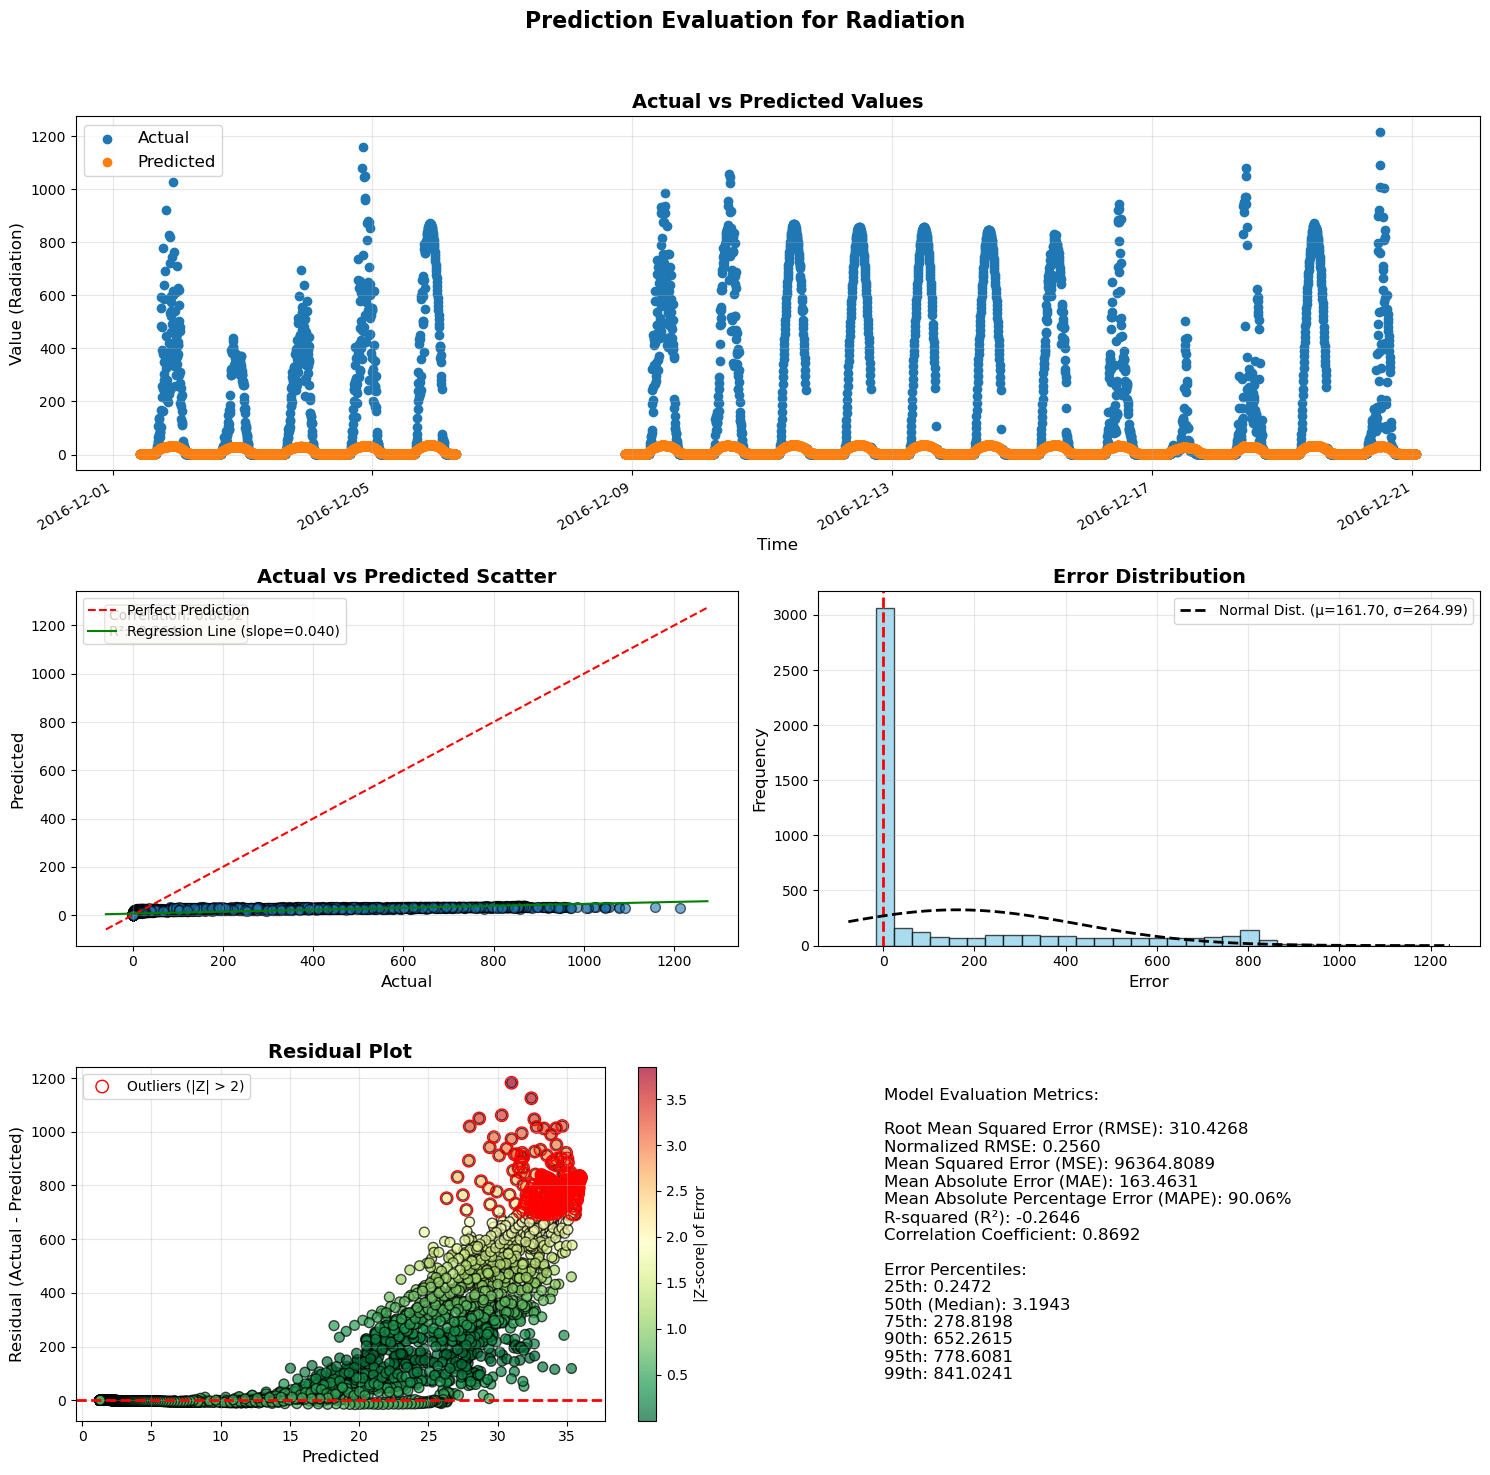

In [12]:
import plot_utils as pu 

# You can create timestamps if data has a time component
timestamps = df['UNIXTime'].values[-len(predictions_original_scale):]  # assuming UNIXTime exists in df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions_original_scale, 
    actuals=actuals_original_scale, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)


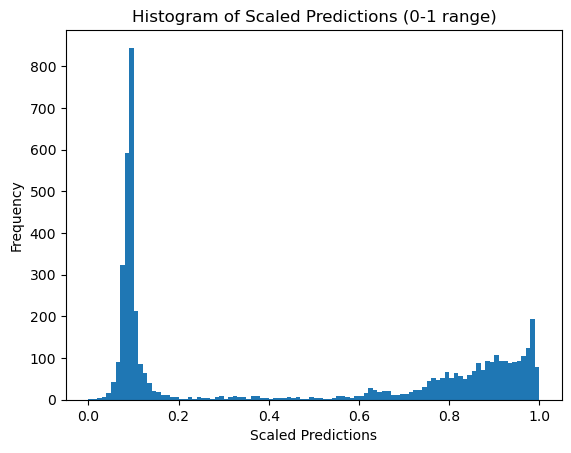

In [12]:
# Scale the data to [0,1] range
model_predictions_scaled = (model_predictions_std_log_np - model_predictions_std_log_np.min()) / (model_predictions_std_log_np.max() - model_predictions_std_log_np.min())

# Plot the scaled predictions
plt.hist(model_predictions_scaled, bins=100)
plt.title('Histogram of Scaled Predictions (0-1 range)')
plt.xlabel('Scaled Predictions')
plt.ylabel('Frequency')
plt.show()


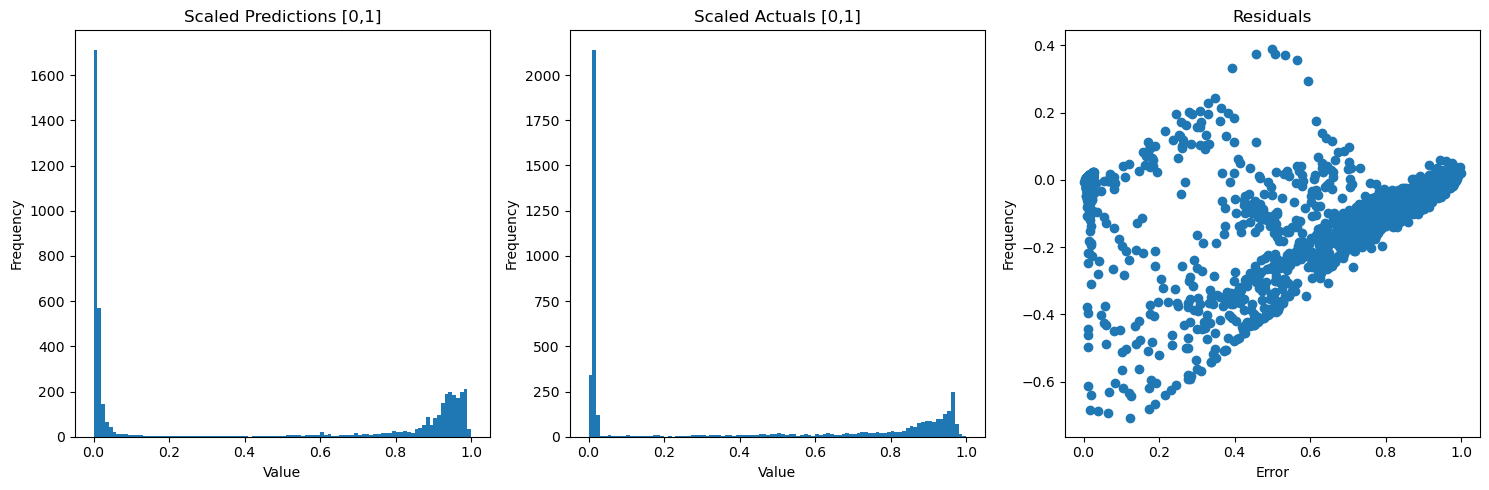


Scaled Data Statistics:
Predictions - Min: 0.0000, Max: 1.0000, Mean: 0.4132
Actuals    - Min: 0.0000, Max: 1.0000, Mean: 0.3731

Residuals Statistics:
Min: -0.7087, Max: 0.3902, Mean: -0.0401, Std: 0.1013


In [15]:
# Scale both predictions and actuals to [0,1] range
model_predictions_scaled = (model_predictions_std_log_np - model_predictions_std_log_np.min()) / (model_predictions_std_log_np.max() - model_predictions_std_log_np.min())
actuals_scaled = (actuals_std_log_np - actuals_std_log_np.min()) / (actuals_std_log_np.max() - actuals_std_log_np.min())

# Calculate residuals
residuals = actuals_scaled - model_predictions_scaled

# Plot histograms
plt.figure(figsize=(15, 5))

# Plot scaled predictions
plt.subplot(131)
plt.hist(model_predictions_scaled, bins=100)
plt.title('Scaled Predictions [0,1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot scaled actuals
plt.subplot(132)
plt.hist(actuals_scaled, bins=100)
plt.title('Scaled Actuals [0,1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot residuals
plt.subplot(133)
plt.scatter(actuals_scaled, residuals)
plt.title('Residuals')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nScaled Data Statistics:")
print(f"Predictions - Min: {model_predictions_scaled.min():.4f}, Max: {model_predictions_scaled.max():.4f}, Mean: {model_predictions_scaled.mean():.4f}")
print(f"Actuals    - Min: {actuals_scaled.min():.4f}, Max: {actuals_scaled.max():.4f}, Mean: {actuals_scaled.mean():.4f}")
print(f"\nResiduals Statistics:")
print(f"Min: {residuals.min():.4f}, Max: {residuals.max():.4f}, Mean: {residuals.mean():.4f}, Std: {residuals.std():.4f}")

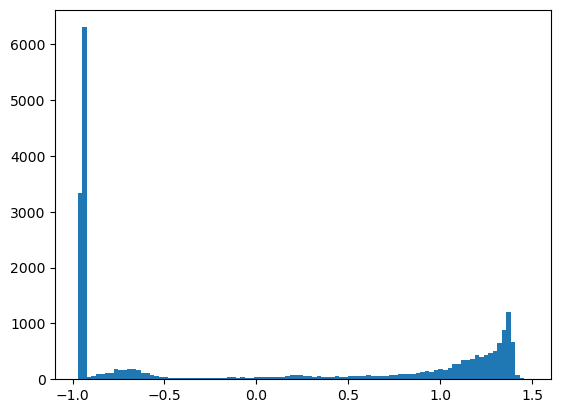

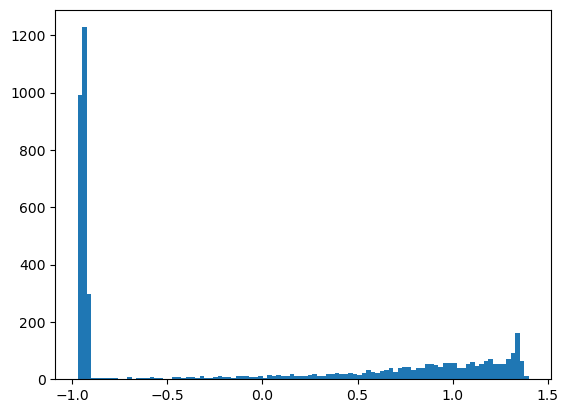

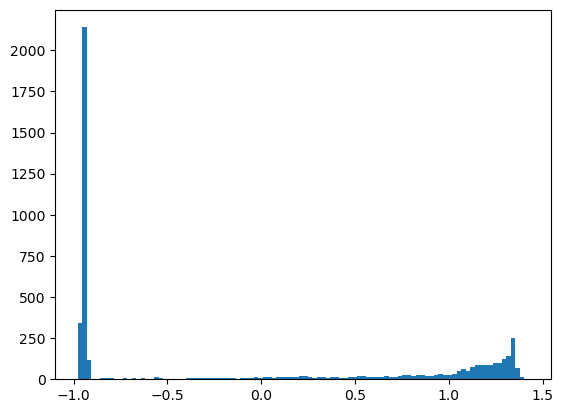

In [16]:
#plot histogram of y train
plt.hist(y_train, bins=100)
plt.show()

#plot histogram of y val
plt.hist(y_val, bins=100)
plt.show()

plt.hist(y_test, bins=100)
plt.show()


In [17]:
print(model.fc3.bias.item())
print(model.fc3.weight)


0.05188759043812752
Parameter containing:
tensor([[ 0.0440,  0.0779,  0.0657, -0.1508,  0.0867,  0.0483, -0.1137, -0.0989,
         -0.1305, -0.1771, -0.1345, -0.0787, -0.1681,  0.0413,  0.0677,  0.0932,
          0.0642, -0.2249, -0.1253, -0.0663,  0.0851,  0.0687,  0.0626, -0.1275,
         -0.1040,  0.1189, -0.1228,  0.0530, -0.0417, -0.1421, -0.0658, -0.1113,
         -0.0764,  0.0901,  0.0248, -0.0727,  0.0760,  0.0963,  0.0847,  0.0788,
          0.0533, -0.1137,  0.0575,  0.1734,  0.0216,  0.0386, -0.0894, -0.1245,
         -0.1394, -0.1412, -0.0945,  0.0420, -0.1333, -0.0939,  0.0621,  0.1086,
         -0.0506, -0.1381, -0.1390, -0.1117,  0.0327, -0.0649,  0.0585,  0.3722]],
       requires_grad=True)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [ ]:
model.save('weather_lstm_model.pt')

# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.